# Analyzing Baltimore's Crime Related Factors

### Group member:
Tianyu Zhang, Xinyue Li
### Outline
- 1. Introduction
    - 1.1 Background Information
    - 1.2 Library Used
- 2. Data Collection
    - 2.1 Data Reference
    - 2.2 Collecting and Parsing
    - 2.3 Cleaning data
    - 2.4 Pre-processing
- 3. Data Visualization & Analysis
    - 3.1 Overall distribution
        - 3.1.1 Age
        - 3.1.2 Top 20 offense type
        - 3.1.3 District
    - 3.2 Trends over 2011-2012
        - 3.2.1 By gender
        - 3.2.2 By race
- 4. Machine Learning
- 5. Final Thoughts

## 1. Introduction
In our final tutorial, we decided to analyze Baltimore's crime case(proportion of gender, race, location, and offense type) and see if there is a relationship between the crime number with gender, age, and race from January 2011 to December 2012. Suppose there is no clear relationship with these factors. In that case, we are going to analyze the changes of overall crime cases over two years, like which season is the peak season for crime, and predict the future tendency for criminal cases in Baltimore. 

### 1.1 Background information and why we choose this topic 
Baltimore in Maryland is notorious for its significantly high crime rate. In 2011, there were 196 homicides reported, which was the first time the city has less than 200 homicides after 1978. Also, for us, the international students, we have heard a lot about the crime and safety issues in Baltimore since we began to choose the college to apply to. Our families were pretty worried about our safety since they saw Baltimore was close to College Park (on the map), and they didn't know the specific situation in Baltimore. After we finished project four about the Baltimore arrest cases map, my groupmate and I became more interested in the city and its arrest case information. Hence, we choose this topic and try to figure out any relationship between arrest cases and time, age, race, and gender from 2011 to 2012.

### 1.2 Library Used
- Pandas: Used to display and organize in dataframes
- datetime: Used to supply classes for manipulating dates and times.
- re: Used to clean the offense type by regular expression
- numpy: Used to make array for machine learning
- curve_fit: Used for non-linear regression curve fitting in machine learning
- Seaborn: Used to create plot
- Matplotlib: Used to format plots
- Scikit-learn: Used to create predictive model to group player into position groups

In [1]:
import pandas as pd
import datetime
import re
import numpy as np
from numpy import cos
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from scipy.optimize import curve_fit
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

## 2. Data Collection
We are using the database that consists of the arrest data from 2011 to 2012 in Baltimore. The related features are gender, race, age, arrest date and time, district, and incident offense type. There are other data provided about the specific location of arrest in the database, but we are mainly analyzing the general distribution and the trends over time.

### 2.1 Data Reference
The dataset we used is retrieved from https://cmsc320.github.io/files/BPD_Arrests.csv

Another dataset is used during the analysis, but not the main database: https://datacenter.kidscount.org/data/tables/4461-juvenile-arrests?loc=22&loct=2#detailed/3/106/false/573,869,36,868,867,133,38,35,18/any/10020,15102

### 2.2 Collection and parsing
To begin with, we get the dataset by reading its csv file. For convenience, we splite the 'Location 1' into two parts with its lat and long as the geographic information in the type of float.

In [2]:
arrest_table = pd.read_csv("https://cmsc320.github.io/files/BPD_Arrests.csv")
arrest_table["lat"], arrest_table["long"] = arrest_table["Location 1"].str.split(",").str
arrest_table["lat"] = arrest_table["lat"].str.replace("(", "").astype(float)
arrest_table["long"] = arrest_table["long"].str.replace(")", "").astype(float)
a_table = arrest_table.loc[:, ['age', 'race','sex','arrestDate','arrestTime', 'incidentOffense', 'district', 'lat', 'long']]
a_table.head()

C:\Users\Tianyu Zhang\AppData\Local\Temp\ipykernel_28512\3722697467.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  arrest_table["lat"], arrest_table["long"] = arrest_table["Location 1"].str.split(",").str
C:\Users\Tianyu Zhang\AppData\Local\Temp\ipykernel_28512\3722697467.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  arrest_table["lat"] = arrest_table["lat"].str.replace("(", "").astype(float)
C:\Users\Tianyu Zhang\AppData\Local\Temp\ipykernel_28512\3722697467.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  arrest_table["long"] = arrest_table["long"].str.replace(")", "").astype(float)


,age,race,sex,arrestDate,arrestTime,incidentOffense,district,lat,long
0,23,B,M,01/01/2011,00:00:00,Unknown Offense,NaN,NaN,NaN
1,37,B,M,01/01/2011,00:01:00,79-Other,SOUTHERN,39.281403,-76.648364
2,46,B,M,01/01/2011,00:01:00,Unknown Offense,NORTHEASTERN,39.322770,-76.573575
3,50,B,M,01/01/2011,00:04:00,79-Other,WESTERN,39.311720,-76.662355
4,33,B,M,01/01/2011,00:05:00,Unknown Offense,NORTHERN,39.338289,-76.604567


### 2.3 Cleaning data
We remove the incorrect, duplicate and incomplete data in the cells.(Observed by unique() function and subjectively identifed)
1. drop the data with age 0
2. group by the ages
3. clean up the offense type by ignoring the subtype
4. change date into year-month format

#### 2.3.1 drop the data with age 0

By unique() function and viewing over the dataset, we found that there are some records saying the arrest's age is 0, which is nonsense and should be caused by missing data or system error. This might be influential to the analysis we will make further, so we clean it by dropping the related rows.

In [47]:
a_table = a_table[a_table.age != 0]
a_table = a_table.reset_index(drop=True)
a_table.head()

,age,race,sex,arrestDate,arrestTime,incidentOffense,district,lat,long
0,23,B,M,01/01/2011,00:00:00,Unknown Offense,NaN,NaN,NaN
1,37,B,M,01/01/2011,00:01:00,79-Other,SOUTHERN,39.281403,-76.648364
2,46,B,M,01/01/2011,00:01:00,Unknown Offense,NORTHEASTERN,39.322770,-76.573575
3,50,B,M,01/01/2011,00:04:00,79-Other,WESTERN,39.311720,-76.662355
4,33,B,M,01/01/2011,00:05:00,Unknown Offense,NORTHERN,39.338289,-76.604567


#### 2.3.2 group by the ages
To make it easier to visualize the relationship between age stage and arrested number, we group the arrested cases by their ages and set them into six different age stages, which are 0-17 18-29 30-39 40-49 50-59 and 60-90. Except the first and last stages, the other age intervals all have 10 years as their range. Also, the first and last intervals are special since the contained cases are already relatively small, which means if we splite them into 10 years bin, it wouldn't be helpful for visualization. 

In [48]:
# group the data by age
bins = [0,17,29,39,49,59,90]
a_table['age_group'] = pd.cut(a_table['age'], bins)

a_table.head()

,age,race,sex,arrestDate,arrestTime,incidentOffense,district,lat,long,age_group
0,23,B,M,01/01/2011,00:00:00,Unknown Offense,NaN,NaN,NaN,"(17, 29]"
1,37,B,M,01/01/2011,00:01:00,79-Other,SOUTHERN,39.281403,-76.648364,"(29, 39]"
2,46,B,M,01/01/2011,00:01:00,Unknown Offense,NORTHEASTERN,39.322770,-76.573575,"(39, 49]"
3,50,B,M,01/01/2011,00:04:00,79-Other,WESTERN,39.311720,-76.662355,"(49, 59]"
4,33,B,M,01/01/2011,00:05:00,Unknown Offense,NORTHERN,39.338289,-76.604567,"(29, 39]"


In [49]:
# Create a new groupby object `grouped2` with year_group as the column
grouped2 = a_table.groupby(by='age_group')
age_label = []
age_count = []
for name, group in grouped2:
    age_label.append(str(name))
    age_count.append(len(group))
    print(name, len(group))

(0, 17] 440
(17, 29] 49278
(29, 39] 22069
(39, 49] 20846
(49, 59] 10133
(59, 90] 1739


#### 2.3.3 clean up the offense type by ignoring the subtype
After cleaning the age column, we also found that the offense type column is also a cluster with some duplicated types. For example, by unique() function, we can see that there are many type 6 offenses like 6D-Larceny- From Auto, 6C-Larceny- Shoplifting, 6E-Larceny- Auto Acc, 6H-Larceny- From Machine, etc. However, all of them are under the offense name of 'Larceny.' Hence, we decided to clean this data column to ensure the result in further operations will be accurate and correct.

In [50]:
# find the types of incident offense
a_table['incidentOffense'].unique()

array(['Unknown Offense', '79-Other', '81-Recovered Property',
       '54-Armed Person', '20A-Followup', '4E-Common Assault',
       '7A-Stolen Auto', '87-Narcotics', '4B-Agg. Asslt.- Cut',
       '75-Destruct. Of Property', '55-Disorderly Person',
       '4C-Agg. Asslt.- Oth.', '49-Family Disturbance',
       '4D-Agg. Asslt.- Hand', '3B-Robb Highway (Ua)',
       '6D-Larceny- From Auto', '5A-Burg. Res. (Force)',
       '111-Protective Order', '24-Towed Vehicle',
       '87O-Narcotics (Outside)', '29-Driving While Intox.',
       '6G-Larceny- From Bldg.', '97-Search & Seizure',
       '55A-Prostitution', '115-Trespassing', '5D-Burg. Oth. (Force)',
       '85-Mental Case', '5B-Burg. Res. (Att.)', '6J-Larceny- Other',
       '23-Unauthorized Use', '3JK-Robb Residence-Knife',
       '4F-Assault By Threat', '3LF-Robb Bank-Firearm',
       '6C-Larceny- Shoplifting', '4A-Agg. Asslt.- Gun',
       '61-Person Wanted On War', '8J-Arson Other', '109-Loitering',
       '6E-Larceny- Auto Acc', '3A

We relabel the offense types with their type ID by ignoring the subtypes of them and set them into a new column named offense_type. Then we drop the original duplicated column. For further use, we collected the offense type names with different type IDs in the list called offense_label, which can be used in collecting results and analyzing our conclusion.

In [51]:
# ignore the subtypes of the offense
offense_label = [
    '1-Murder',
    '2-Sexual Asslt.',
    '3-Robbery',
    '4-Agg. Asslt.',
    '5-Burglary',
    '6-Larceny',
    '7-Stolen Property',
    '8-Arson',
    '13-Assist Officer',
    '20-Traffic',
    '23-Unauthorized Use',
    '24-Towed Vehicle',
    '26-Recovered Vehicle',
    '28-Suicide - Attempt',
    '29-Driving While Intox.',
    '39-Fire',
    '48-Involuntary Detention',
    '49-Family Disturbance',
    '52-Animal Cruelty',
    '54-Armed Person',
    '55-Disorderly Person',
    '56-Missing Person',
    '58-Injured Person',
    '59-Intoxicated Person',
    '60-Sick Person',
    '61-Person Wanted On War',
    '62-Person Lying On St.',
    '64-Drug Free Zone',
    '67-Child Abuse-Physical',
    '70-Sanitation Complaint',
    '71-Sex Offender Registry',
    '73-False Pretense',
    '75-Destruct. Of Property',
    '76-Child Abuse-Sexual',
    '77-Dog Bite',
    '78-Gambling',
    '79-Other',
    '80-Lost Property',
    '81-Recovered Property',
    '83-Discharging Firearm',
    '84-Bomb Scare',
    '85-Mental Case',
    '87-Narcotics',
    '88-Unfounded Call',
    '93-Abduction - Other',
    '94-Abduction By Parent',
    '95-Exparte',
    '96-Stop & Frisk',
    '97-Search & Seizure',
    '98-Child Neglect',
    '102-Questional Death',
    '103-Dead On Arrival',
    '112-Traffic Related Incident',
    '106-Custody Dispute',
    '108-Liquor Law/Open Container',
    '109-Loitering',
    '110-Summons Served',
    '111-Protective Order',
    '112-Traffic Related Incident',
    '113-Littering',
    '114-Hindering',
    '115-Trespassing',
    '116-Public Urination / Defecation',
    '117-Fto',
    'Unknown Offense',
]

a_table['offense_type'] = np.nan
for idx, row in a_table.iterrows():
    if  row['incidentOffense'] == "Unknown Offense":
        a_table.loc[idx, 'offense_type'] = 0
    else:
        a_table.loc[idx, 'offense_type'] = int(re.search(r'\d+', row['incidentOffense']).group())          
a_table

,age,race,sex,arrestDate,arrestTime,incidentOffense,district,lat,long,age_group,offense_type
0,23,B,M,01/01/2011,00:00:00,Unknown Offense,NaN,NaN,NaN,"(17, 29]",0.0
1,37,B,M,01/01/2011,00:01:00,79-Other,SOUTHERN,39.281403,-76.648364,"(29, 39]",79.0
2,46,B,M,01/01/2011,00:01:00,Unknown Offense,NORTHEASTERN,39.322770,-76.573575,"(39, 49]",0.0
3,50,B,M,01/01/2011,00:04:00,79-Other,WESTERN,39.311720,-76.662355,"(49, 59]",79.0
4,33,B,M,01/01/2011,00:05:00,Unknown Offense,NORTHERN,39.338289,-76.604567,"(29, 39]",0.0
...,...,...,...,...,...,...,...,...,...,...,...
104500,27,B,M,12/31/2012,23:10:00,Unknown Offense,CENTRAL,39.289332,-76.621002,"(17, 29]",0.0
104501,34,B,M,12/31/2012,23:30:00,4E-Common Assault,NORTHEASTERN,39.325261,-76.568903,"(29, 39]",4.0
104502,38,B,M,12/31/2012,23:40:00,87-Narcotics,WESTERN,39.311684,-76.647501,"(29, 39]",87.0
104503,18,W,F,12/31/2012,23:43:00,Unknown Offense,NaN,NaN,NaN,"(17, 29]",0.0


#### 2.3.4 change date into year-month format
To figure out the relationship between different factors and time, we need to transfer the column info into DateTime and year-month format (if we keep the original year-month-day format, the plot will be zigzag and not helpful for analysis).

In [52]:
# change the arrest date into "year-month" format
a_table['arrestDate'] = pd.to_datetime(a_table['arrestDate']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
a_table.head()

,age,race,sex,arrestDate,arrestTime,incidentOffense,district,lat,long,age_group,offense_type
0,23,B,M,2011-1,00:00:00,Unknown Offense,NaN,NaN,NaN,"(17, 29]",0.0
1,37,B,M,2011-1,00:01:00,79-Other,SOUTHERN,39.281403,-76.648364,"(29, 39]",79.0
2,46,B,M,2011-1,00:01:00,Unknown Offense,NORTHEASTERN,39.322770,-76.573575,"(39, 49]",0.0
3,50,B,M,2011-1,00:04:00,79-Other,WESTERN,39.311720,-76.662355,"(49, 59]",79.0
4,33,B,M,2011-1,00:05:00,Unknown Offense,NORTHERN,39.338289,-76.604567,"(29, 39]",0.0


### 2.4 Pre-processing
As we need to visualize the data across time, new tables are made
1. arrest counts for time, sex, and race

In [53]:
# create a new table about time, sex, and race
time_df = pd.DataFrame(data=a_table['arrestDate'])
time_line = pd.unique(a_table['arrestDate'])
time_df = pd.DataFrame(time_line, columns = ['Time'])
time_df['F'] = 0
time_df['M'] = 0
time_df['African_American'] = 0
time_df['White'] = 0
time_df['Indian_American'] = 0
time_df['Asian'] = 0
time_df['Pacific_Islander'] = 0
time_df.head()

,Time,F,M,African_American,White,Indian_American,Asian,Pacific_Islander
0,2011-1,0,0,0,0,0,0,0
1,2011-2,0,0,0,0,0,0,0
2,2011-3,0,0,0,0,0,0,0
3,2011-4,0,0,0,0,0,0,0
4,2011-5,0,0,0,0,0,0,0


In [54]:
# add data to the table
time_df['F'] = a_table[a_table['sex'] == 'F'].groupby(by='arrestDate', as_index = False)['sex'].count()['sex']
time_df['M'] = a_table[a_table['sex'] == 'M'].groupby(by='arrestDate', as_index = False)['sex'].count()['sex']
time_df['African_American'] = a_table[a_table['race'] == 'B'].groupby(by='arrestDate', as_index = False)['race'].count()['race']
time_df['White'] = a_table[a_table['race'] == 'W'].groupby(by='arrestDate', as_index = False)['race'].count()['race']
time_df['Indian_American'] = a_table[a_table['race'] == 'I'].groupby(by='arrestDate', as_index = False)['race'].count()['race']
time_df['Asian'] = a_table[a_table['race'] == 'A'].groupby(by='arrestDate', as_index = False)['race'].count()['race']
time_df['Pacific_Islander'] = a_table[a_table['race'] == 'A'].groupby(by='arrestDate', as_index = False)['race'].count()['race']

In [55]:
time_df.head()

,Time,F,M,African_American,White,Indian_American,Asian,Pacific_Islander
0,2011-1,657,2954,3038,490,7,12,12
1,2011-2,815,3788,3880,626,7,7,7
2,2011-3,735,3415,3463,579,14,9,9
3,2011-4,694,3282,3338,543,10,8,8
4,2011-5,734,3251,3343,545,11,9,9


## 3. Data visualization & Analysis
We analysis the data in two category: overall over 2011-2012 and the trend over the two years. 

### 3.1 Overall distribution

#### 3.1.1 Age

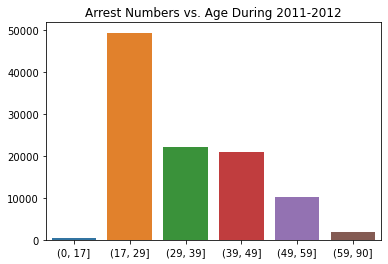

In [56]:
# bar plot of age distribution
sns.barplot(x=age_label, y=age_count)
plt.title("Arrest Numbers vs. Age During 2011-2012")
plt.show()

The number of arrest of age 20 to 29 is obviously the higest among all any other groups. The overall distribution is consistant to the common sense. 
However, the age from 17 to 29 jumps a lot. Hence, An additional statistics need to be mentioned here. The juvenile crime used to be a main issue over the country, especially Baltimore district. However, The juvenile crime rate has been dropping incredibly since 2000. The data from https://datacenter.kidscount.org/data/tables/4461-juvenile-arrests?loc=22&loct=2#detailed/3/106/false/573,869,36,868,867,133,38,35,18/any/10020,15102 aside the dataset we use is provided and a line plot is done below.

In [57]:
juv_df = pd.read_excel('Juvenile arrests.xlsx')
juv_df = juv_df[juv_df['Location'] == 'Baltimore']
juv_df = juv_df[juv_df['DataFormat'] == 'Number']
juv_df

,LocationType,Location,TimeFrame,DataFormat,Data
30,City,Baltimore,2005,Number,10628.0
32,City,Baltimore,2006,Number,10547.0
34,City,Baltimore,2007,Number,8681.0
36,City,Baltimore,2008,Number,8179.0
38,City,Baltimore,2009,Number,6581.0
40,City,Baltimore,2010,Number,5547.0
42,City,Baltimore,2011,Number,4227.0
44,City,Baltimore,2012,Number,4139.0
46,City,Baltimore,2013,Number,3726.0
48,City,Baltimore,2014,Number,3439.0


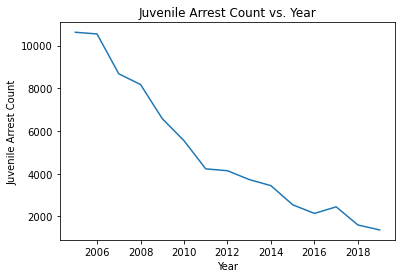

In [58]:
plt.plot(juv_df['TimeFrame'], juv_df['Data'])
plt.title('Juvenile Arrest Count vs. Year')
plt.xlabel('Year')
plt.ylabel('Juvenile Arrest Count')
plt.show()

It can be noticed that among all the age groups, the dropping of arrest count of juvenile is the most obvious, which is a good thing. And it can be also notified that the crime eduation of juvenile has been doing a great work and the police should move the attention to the 18~30 age group.

#### 3.1.2 Top 20 offenses

In [59]:
# bar plot for top 20 offense and the rest
a_table['offense_type'].astype(int)
offense_range = list(set(a_table['offense_type']))
offense_count = [0]*len(offense_range)

for idx, row in a_table.iterrows():
  offense_count[offense_range.index(row['offense_type'])] += 1

offense = {'type':offense_range, 'count':offense_count}
df_offense = pd.DataFrame(offense)
df_offense.sort_values(by='count', ascending=False, inplace=True)

offense_others = df_offense[21:]

sum = offense_others.sum(axis=0)['count']
df_sum = pd.DataFrame(columns=['type', 'count'])
df_sum = df_sum.append({'type': "rest", 'count': sum}, ignore_index=True)

x_count = df_offense[1:21]
x_count = x_count.append(df_sum)

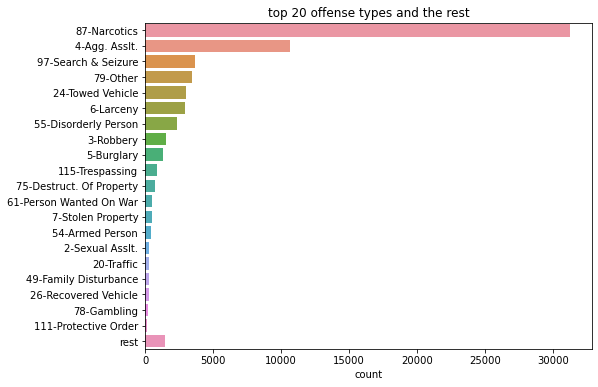

In [60]:
label = [
    '87-Narcotics',
    '4-Agg. Asslt.',
    '97-Search & Seizure',
    '79-Other',
    '24-Towed Vehicle',
    '6-Larceny',
    '55-Disorderly Person',
    '3-Robbery',
    '5-Burglary',
    '115-Trespassing',
    '75-Destruct. Of Property',
    '61-Person Wanted On War',
    '7-Stolen Property',
    '54-Armed Person',
    '2-Sexual Asslt.',
    '20-Traffic',
    '49-Family Disturbance',
    '26-Recovered Vehicle',
    '78-Gambling',
    '111-Protective Order',
    'rest'
]
plt.figure(figsize=(8,6))
sns.barplot(x=x_count['count'], y=label)
plt.title("top 20 offense types and the rest")
plt.show()

Top 1 aside "Unknown offense" is Narcotics, which is not surprising based on the fact that pot's smell can be noticed on almost daily bases even in College Park. Top 2 is not surprising either. With the high rate of firearm in Baltimore district, it is very likely to be assaulted on the street while the offenser is holding a gun or knife. 

However, there are some types that is not easily noticed. For example, 61-Person Wanted On War or 78-Gambling. This is the top 20 among about 100 types of offense. So Gambling is higher than we thought. Moreover, there is a category of "Unknown offense" not graphed in the chart, which is about 1/3 of all the data. This is one thing that we cannot figure out why.

#### 3.1.3 District 

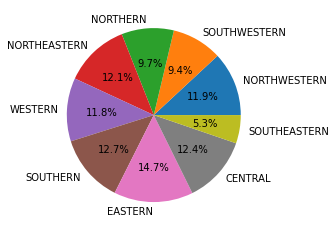

In [61]:
# pie chart for district distribution
district_range = list(set(a_table['district']))
district_labels = ['NORTHWESTERN', 'SOUTHWESTERN', 'NORTHERN', 'NORTHEASTERN', 'WESTERN', 'SOUTHERN', 'EASTERN', 'CENTRAL', 'SOUTHEASTERN']
district_count = [0]*len(district_range)

for idx, row in a_table.iterrows():
  district_count[district_range.index(row['district'])] += 1

# drop district nan
district_range.pop(0)
district_count.pop(0)

# plot
plt.pie(district_count, labels = district_labels, autopct='%1.1f%%')
plt.show()

It can be noticed from the pie chart that "WESTERN" district has the lowest arrest rate while "SOUTHEASTERN" has the highest. This number can be explained by the resident distribution in Baltimore. Therefore, it can be concluded that there is no such district that is more dangerous or less dangerous than the others for both criminal and civilians.

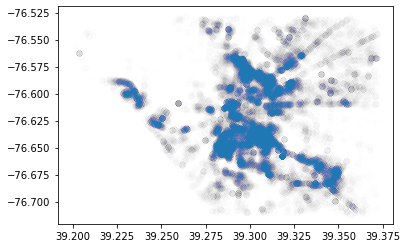

In [62]:
plt.scatter(arrest_table['lat'],arrest_table['long'],alpha=0.005)

This is the distribution map of recorded arrested cases in Baltimore by its location, and from this plot, we can see that the cases are overall uniformly distributed in Baltimore with the least in Western, which states the result we get from the last pie plot. Also, it is pretty interesting that although we know the arrested cases in central part is not the highest, but it is the most intenive in central part, which we speculate that it is because the higer crime rate neighborhoods are often close to each other, and sometimes when a neighboorhood has a frequent crime rate, it would also impact its adjacent communities. 

### 3.2 Changes over time (Monthly)

#### 3.2.1 By gender

C:\Users\Tianyu Zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tianyu Zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


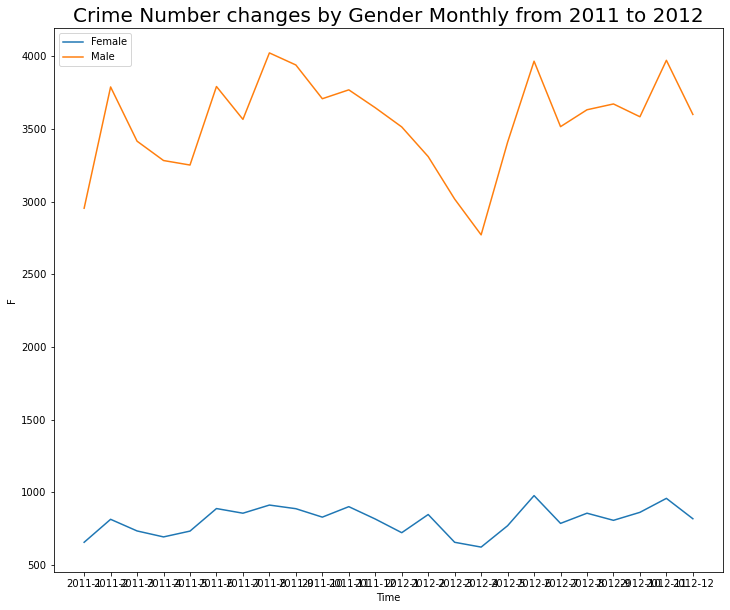

In [63]:
plt.figure(figsize=(12,10))
plt.title('Crime Number changes by Gender Monthly from 2011 to 2012', fontsize=20)
sns.lineplot(time_df.Time, time_df.F,ci=None)
sns.lineplot(time_df.Time, time_df.M,ci=None)
plt.legend(["Female", 'Male'])
plt.show()

#### 3.2.2 By race

In [64]:
time_df.head()

,Time,F,M,African_American,White,Indian_American,Asian,Pacific_Islander
0,2011-1,657,2954,3038,490,7,12,12
1,2011-2,815,3788,3880,626,7,7,7
2,2011-3,735,3415,3463,579,14,9,9
3,2011-4,694,3282,3338,543,10,8,8
4,2011-5,734,3251,3343,545,11,9,9


C:\Users\Tianyu Zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tianyu Zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tianyu Zhang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C

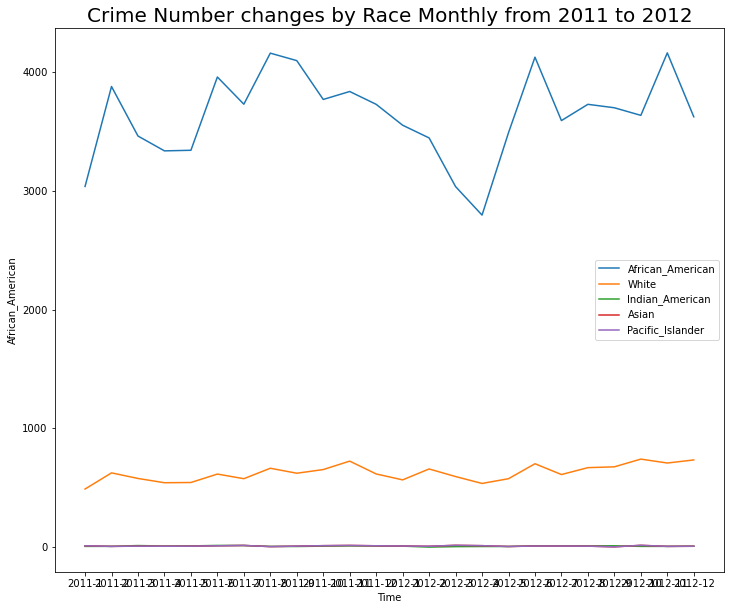

In [65]:
plt.figure(figsize=(12,10))
plt.title('Crime Number changes by Race Monthly from 2011 to 2012', fontsize=20)
sns.lineplot(time_df.Time, time_df.African_American,ci=None)
sns.lineplot(time_df.Time, time_df.White,ci=None)
sns.lineplot(time_df.Time, time_df.Indian_American,ci=None)
sns.lineplot(time_df.Time, time_df.Asian,ci=None)
sns.lineplot(time_df.Time, time_df.Pacific_Islander,ci=None)
plt.legend(['African_American', 'White','Indian_American', 'Asian', 'Pacific_Islander'])
plt.show()

It is pretty interesting since we can see that the trendencies of Male and African American in these two plots were almost same. In other words, the African American group and male group have a huge mutually possessive part. And also, we can see from this plot that the Asian, Indian American, and Pacific Islander have a very low occurence rate over these two years, which we believed is caused by their low population ratio in Baltimore. 

## 4. Machine Learning

### Sin curve fitting for general arrest number pattern across time

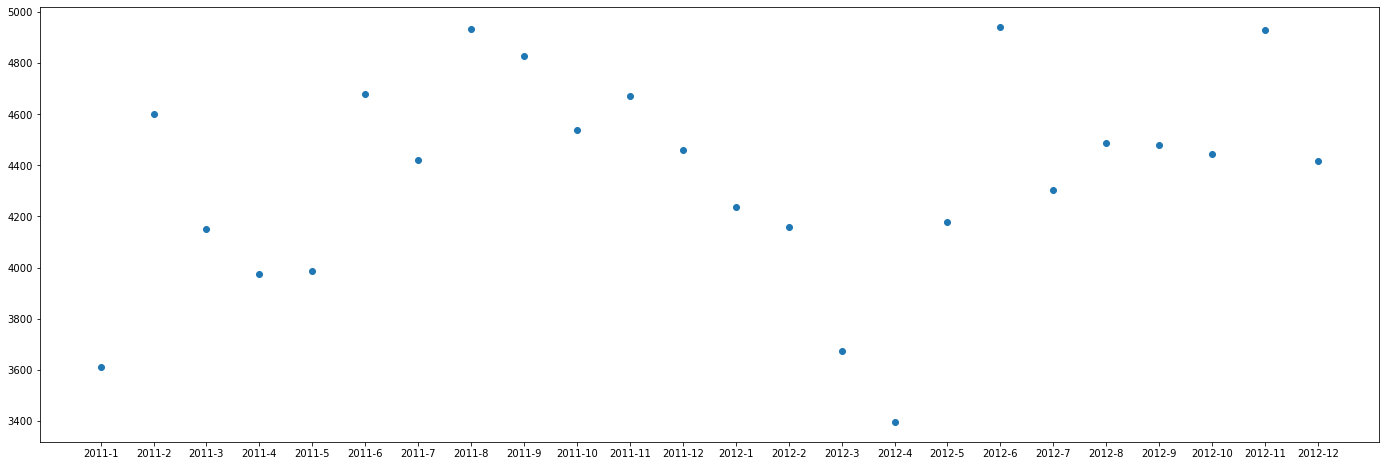

In [66]:
time_df['total'] = time_df['F'] + time_df['M']
plt.figure(figsize=(24,8))
plt.scatter(time_df['Time'], time_df['total'])

In [67]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
y = time_df['total']

def test_func(x, a, b):
    return a * np.sin(b * np.array(x))

params, params_cov = optimize.curve_fit(test_func, x, y, p0=[0, 100])

print(params)

[406.63141624 100.01773594]


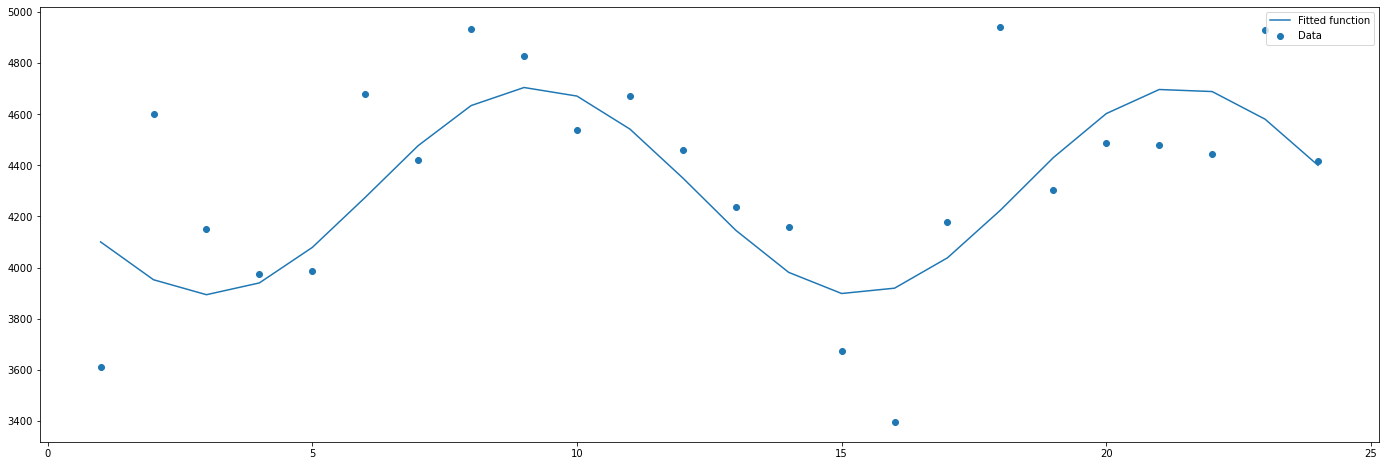

In [68]:
plt.figure(figsize=(24,8))
plt.scatter(x, y, label='Data')
plt.plot(x, test_func(x, params[0], params[1])+4300, label='Fitted function')
plt.legend(loc='best')
plt.show()

**Note that 1~24 is the months from 2011-01 to 2012-12**

It can be view from the fitting curve that the crime rate is high in the summer (2011-8 and 9 and 2012-8 and 9) and low in the winter (2011-3 and 4 and 2012-3 and 4). Theories from criminology also support this conclusion, stating that hot temperature makes people more restless and more likely to commit a crime.To testify our statement, we viewed some related resources and journals, and found this thought is also stated by Janet Lauritsen and Nicole White. Here is the link to their article. https://www.bjs.gov/content/pub/pdf/spcvt.pdf

**Reference**
Lauritsen, Janet L., and Nicole White. Seasonal patterns in criminal victimization trends. US Department of Justice, Office of Justice Programs, Bureau of Justice Statistics, 2014.

## 5. Final Thoughts

The data is the arrest number from 2011-2012. Even though this is not the latest number that can reflect the status quo, it is still be used to study the arrest at that period of time and show suggestions to current policy.

#### 1. Crime prevention education


It has been a long time since Baltimore stands in the center of crime education. Courses are made in schools by both the teachers and police officers. It is because statistics have shown that dropouts are more likely to get arrested. Education has a significant success based on the curve shown in 3.1.1. Therefore, further measures should be taken in public education instead of in schools to prevent crimes committed by people at the age of 1kesh9 to 50.

#### 2. Arrest doesn’t mean crime

This database is about arrest numbers rather than crime numbers. People can get arrested for a number of reasons. For example, “suicide attempt” is listed as an incident offense, while it itself is not a crime. Similar offenses are “disorderly person,” which is listed in the top 10 offenses, “missing person,” “injured person,”… etc. Therefore, when doing further exploration of the database, we need to drop those data if the conclusion is needed for crime.

#### 3. Baltimore is not as dangerous as it is described

Being the “most dangerous” place, Baltimore seems to be somewhere that you should never go to avoid being harmed. However, by looking at the top 20 offense types, it can be noticed most of the crimes committed are not that “attacking.” As long as you travel by car and try to avoid the people that are apparently high, you are safe.